<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Где-брать-данные?" data-toc-modified-id="Где-брать-данные?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Где брать данные?</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Какие-бывают-значения-рейтинга?" data-toc-modified-id="Какие-бывают-значения-рейтинга?-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Какие бывают значения рейтинга?</a></span></li><li><span><a href="#Добавьте-целевую-переменную" data-toc-modified-id="Добавьте-целевую-переменную-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Добавьте целевую переменную</a></span></li><li><span><a href="#Худший-и-лучший-банк" data-toc-modified-id="Худший-и-лучший-банк-2.0.3"><span class="toc-item-num">2.0.3&nbsp;&nbsp;</span>Худший и лучший банк</a></span></li><li><span><a href="#Отличается-ли-длина-у-хороших-и-плохих-отзывов?" data-toc-modified-id="Отличается-ли-длина-у-хороших-и-плохих-отзывов?-2.0.4"><span class="toc-item-num">2.0.4&nbsp;&nbsp;</span>Отличается ли длина у хороших и плохих отзывов?</a></span></li><li><span><a href="#Отличается-ли-распределение-количества-восклицательных-знаков?" data-toc-modified-id="Отличается-ли-распределение-количества-восклицательных-знаков?-2.0.5"><span class="toc-item-num">2.0.5&nbsp;&nbsp;</span>Отличается ли распределение количества восклицательных знаков?</a></span></li></ul></li></ul></li><li><span><a href="#Бейзлайн-модель-классификации" data-toc-modified-id="Бейзлайн-модель-классификации-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Бейзлайн модель классификации</a></span></li><li><span><a href="#Обработка-текста" data-toc-modified-id="Обработка-текста-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обработка текста</a></span><ul class="toc-item"><li><span><a href="#Модель-на-словах.-CountVectorizer" data-toc-modified-id="Модель-на-словах.-CountVectorizer-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Модель на словах. CountVectorizer</a></span></li><li><span><a href="#Модель-на-n-gram'ах-символов.-TfidfVectorizer" data-toc-modified-id="Модель-на-n-gram'ах-символов.-TfidfVectorizer-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Модель на n-gram'ах символов. TfidfVectorizer</a></span></li><li><span><a href="#Подбор-параметров-с-помощью-кросс-валидации" data-toc-modified-id="Подбор-параметров-с-помощью-кросс-валидации-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Подбор параметров с помощью кросс-валидации</a></span></li><li><span><a href="#Объединение-признаков" data-toc-modified-id="Объединение-признаков-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Объединение признаков</a></span></li><li><span><a href="#Визуализация-отзывов" data-toc-modified-id="Визуализация-отзывов-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Визуализация отзывов</a></span></li></ul></li><li><span><a href="#Проблемы-анализа-тональности" data-toc-modified-id="Проблемы-анализа-тональности-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проблемы анализа тональности</a></span></li></ul></div>

In [1]:
import json
import re
import requests

import nltk
nltk.download('stopwords')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing  import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from IPython.core.display import HTML, display

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/k.shematorov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
SEED = 42

TOKEN_PATTERN = "[а-яё]+"

DATA_PATH = 'data/parsed_reviews.csv'

Uncomment if you are using colab

In [7]:
#!mkdir ./data
#!wget https://raw.githubusercontent.com/vadim0912/MLIntro2022_Spring/master/lecture06/data/parsed_reviews.csv.gz -O $DATA_PATH

# Exploratory Data Analysis

In [18]:
!ls -lah $DATA_PATH

-rw-rw-r--  1 k.shematorov  staff   204M 25 май  2022 data/parsed_reviews.csv


In [9]:
!gunzip -c $DATA_PATH | wc -l

  102062


In [3]:
df = pd.read_csv(DATA_PATH, nrows=50_000)

### Какие бывают значения рейтинга?

In [4]:
df['rating'].value_counts()

1    29975
5    13089
2     4570
3     1283
4     1083
Name: rating, dtype: int64

### Добавьте целевую переменную
* $y = 1$, если рейтинг высокий
* $y = 0$, если рейтинг низкий

In [5]:
df = df[df.rating != 3].reset_index(drop=True)

In [6]:
df['y'] = df.rating.apply(lambda x: int(x > 3)).values

In [7]:
df.head()

,body,title,rating,date,bank_name,y
0,Пользуюсь услугами банка около 4х лет.&amp;amp...,Очень эффективный банк,5,2020-10-02,Альфа-Банк,1
1,Несколько лет назад открыл кредитную карту в П...,Бешеные комиссии в Почта банке,1,2020-10-02,Почта Банк,0
2,Решил закрыть карту этого банка. Через чат поп...,Ужасное обслуживание. Пустили по кругу,1,2020-10-02,Хоум Кредит Банк,0
3,"В марте 2020 года я потеряла работу , В конце ...",Сотрудники Сбербанка намерено меня обманули !!!!,1,2020-10-02,СберБанк,0
4,"закончился вклад-депозит. во-первых, клиентски...",невозможно забрать свои же деньги,1,2020-10-02,Банк Открытие,0


какой баланс классов?

In [8]:
df['y'].value_counts()

0    34545
1    14172
Name: y, dtype: int64

### Худший и лучший банк

In [9]:
stat = (
    df[['bank_name',  'date', 'rating']]
    .groupby('bank_name', as_index=False)
    .agg({'date': 'count', 'rating': 'mean'})
    .rename({'date': 'review_count', 'rating': 'mean_rating'}, axis=1)
)

In [10]:
(
    stat[stat['review_count'] > 3_000]
    .sort_values('mean_rating', ascending=False)
)

,bank_name,review_count,mean_rating
163,Совкомбанк,3062,3.285761
172,Тинькофф Банк,4314,2.994669
13,Альфа-Банк,4783,2.426720
154,СберБанк,6368,1.897142
38,ВТБ,5449,1.830428


### Отличается ли длина у хороших и плохих отзывов?

посчитайте длины хороших и плохих отзывов

In [11]:
body_len_0 = df.loc[df['y'] == 0, 'body'].str.len().values
body_len_1 = df.loc[df['y'] == 1, 'body'].str.len().values

постройте гистограммы для для хороших и плохих отзывов (ограничьте максимальную длину `max_body_length`)

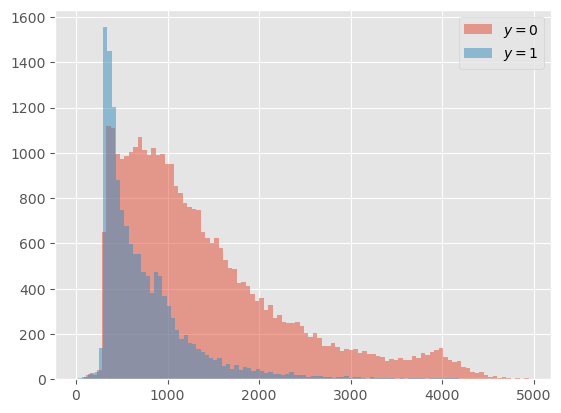

In [12]:
max_body_length = 5_000

bins=100
alpha=0.5

plt.hist(body_len_0[body_len_0 <= max_body_length], alpha=alpha, bins=bins, label=r'$y = 0$')
plt.hist(body_len_1[body_len_1 <= max_body_length], alpha=alpha, bins=bins, label=r'$y = 1$')
plt.legend();

отличаются ли медианы распределений?

In [13]:
np.median(body_len_0), np.median(body_len_1)

(1145.0, 601.0)

### Отличается ли распределение количества восклицательных знаков?

In [14]:
body_exclamation_0 = df[df.y == 0].body.str.count('!')
body_exclamation_1 = df[df.y == 1].body.str.count('!')

title_exclamation_0 = df[df.y == 0].title.str.count('!')
title_exclamation_1 = df[df.y == 1].title.str.count('!')

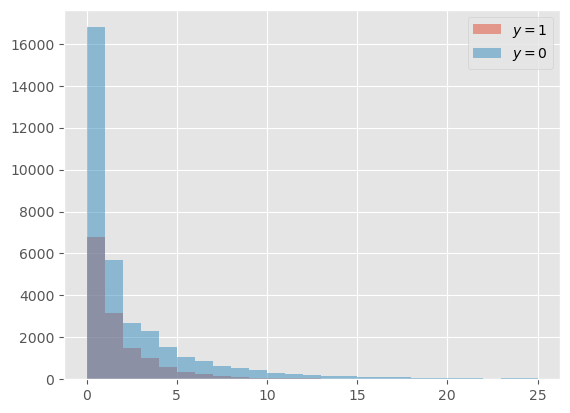

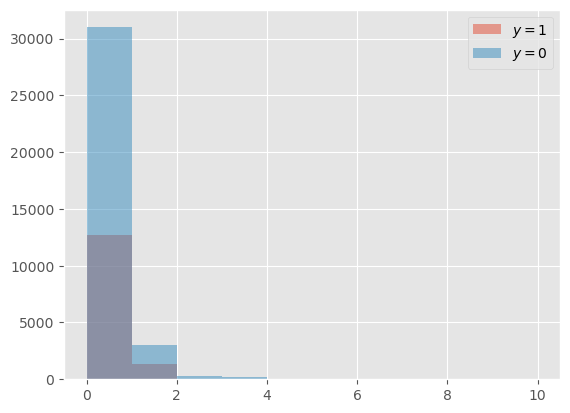

In [15]:
max_symbols = 25
title_max_symbols = 10

plt.hist(
    body_exclamation_1[body_exclamation_1 <= max_symbols],
    label=r'$y = 1$', bins=max_symbols, alpha=alpha
)
plt.hist(
    body_exclamation_0[body_exclamation_0 <= max_symbols],
    label=r'$y = 0$', bins=max_symbols, alpha=alpha
)
plt.legend()
plt.show()

plt.hist(
    title_exclamation_1[title_exclamation_1 <= title_max_symbols],
    label=r'$y = 1$', bins=title_max_symbols, alpha=alpha
)
plt.hist(
    title_exclamation_0[title_exclamation_0 <= title_max_symbols],
    label=r'$y = 0$', bins=title_max_symbols, alpha=alpha
)
plt.legend()
plt.show()

In [16]:
np.median(body_exclamation_0), np.median(body_exclamation_1)

(1.0, 1.0)

# Бейзлайн модель классификации

In [17]:
df['body_len'] = df.body.str.len()
df['title_len'] = df.title.str.len()
df['body_!'] = df.body.str.count('!')
df['title_!'] = df.title.str.count('!')

baseline_features = ['body_len', 'title_len', 'body_!', 'title_!']

In [18]:
df.head()

,body,title,rating,date,bank_name,y,body_len,title_len,body_!,title_!
0,Пользуюсь услугами банка около 4х лет.&amp;amp...,Очень эффективный банк,5,2020-10-02,Альфа-Банк,1,522,22,1,0
1,Несколько лет назад открыл кредитную карту в П...,Бешеные комиссии в Почта банке,1,2020-10-02,Почта Банк,0,1067,30,0,0
2,Решил закрыть карту этого банка. Через чат поп...,Ужасное обслуживание. Пустили по кругу,1,2020-10-02,Хоум Кредит Банк,0,725,38,0,0
3,"В марте 2020 года я потеряла работу , В конце ...",Сотрудники Сбербанка намерено меня обманули !!!!,1,2020-10-02,СберБанк,0,1332,48,1,4
4,"закончился вклад-депозит. во-первых, клиентски...",невозможно забрать свои же деньги,1,2020-10-02,Банк Открытие,0,1352,33,4,0


In [19]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=SEED)

In [20]:
x_train = df_train[baseline_features].values
y_train = df_train.y.values

x_val = df_val[baseline_features].values
y_val = df_val.y.values

In [21]:
baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=SEED, solver='lbfgs', class_weight='balanced'))
]).fit(x_train, y_train)

In [22]:
y_train_pred = baseline.predict(x_train)
f1_score(y_train, y_train_pred)

0.5599253973402529

In [23]:
y_val_pred = baseline.predict(x_val)
f1_score(y_val, y_val_pred)

0.5661788617886179

оцените важность признаков. проинтерпретируйте полученный результат

In [24]:
baseline_clf = baseline.steps[1][1]

In [25]:
baseline_features

['body_len', 'title_len', 'body_!', 'title_!']

In [30]:
baseline_clf?

In [28]:
baseline_clf.coef_

array([[-1.01917758, -0.46866134, -0.09123499,  0.02989326]])

In [27]:
baseline_clf.intercept_

array([-0.30513707])

# Обработка текста

## Модель на словах. CountVectorizer

In [37]:
stop_words = nltk.corpus.stopwords.words('russian')
stop_words

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [32]:
count_model = Pipeline([
    (
        'vectorizer',
        CountVectorizer(
            lowercase=True, ngram_range=(1, 1), token_pattern=TOKEN_PATTERN,
            stop_words=stop_words, min_df=3, max_df=0.8
        )
    ),
    ('clf', SGDClassifier(random_state=SEED, loss='log', class_weight='balanced'))
])

In [33]:
x_train = df_train['body'].values
x_val = df_val['body'].values

In [34]:
count_model.fit(x_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.8, min_df=3,
                                 stop_words=['и', 'в', 'во', 'не', 'что', 'он',
                                             'на', 'я', 'с', 'со', 'как', 'а',
                                             'то', 'все', 'она', 'так', 'его',
                                             'но', 'да', 'ты', 'к', 'у', 'же',
                                             'вы', 'за', 'бы', 'по', 'только',
                                             'ее', 'мне', ...],
                                 token_pattern='[а-яё]+')),
                ('clf',
                 SGDClassifier(class_weight='balanced', loss='log',
                               random_state=42))])

In [40]:
vectorizer = count_model.steps[0][1]

features = np.array(sorted(vectorizer.vocabulary_))

len(features)

41085

In [44]:
count_features = vectorizer.transform(x_train[[0]]).toarray()[0]

In [45]:
x_train[[0]]

array(['При оформлении автокредита навязали услугу &amp;quot;помощь на дорогах&amp;quot; за 10000р без которой не одобряют кредит. Она мне не нужна, да и воспользоваться ей не могу из-за удаленности проживания. А для удобства оплаты кредита оформили карту Золотой ключ которая как в последствии оказалась стоит 4999р. и включена в кредит. Расторгать договора отказываются. Первый и последний раз пользуюсь этим банком. Ни кому не рекомендую.'],
      dtype=object)

In [46]:
pd.DataFrame({
    'token': features[count_features > 0], 
    'count': count_features[count_features > 0]
})

,token,count
0,автокредита,1
1,банком,1
2,включена,1
3,воспользоваться,1
4,договора,1
5,дорогах,1
6,золотой,1
7,карту,1
8,ключ,1
9,кому,1


In [47]:
f1_score(y_train, count_model.predict(x_train))

0.9951080085747265

In [48]:
f1_score(y_val, count_model.predict(x_val))

0.9075194468452896

In [49]:
tree_model = Pipeline([
    (
        'vectorizer',
        CountVectorizer(
            lowercase=True, ngram_range=(1, 1), token_pattern=TOKEN_PATTERN,
            stop_words=stop_words, min_df=3, max_df=0.8
        )
    ),
    ('clf', DecisionTreeClassifier(random_state=SEED, criterion='entropy', max_depth=10))
])

обучите деревянную модель. сравните качество на тренировочном и валидационном наборах

In [50]:
tree_model.fit(x_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.8, min_df=3,
                                 stop_words=['и', 'в', 'во', 'не', 'что', 'он',
                                             'на', 'я', 'с', 'со', 'как', 'а',
                                             'то', 'все', 'она', 'так', 'его',
                                             'но', 'да', 'ты', 'к', 'у', 'же',
                                             'вы', 'за', 'бы', 'по', 'только',
                                             'ее', 'мне', ...],
                                 token_pattern='[а-яё]+')),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        random_state=42))])

In [51]:
f1_score(
    y_train,
    tree_model.predict(x_train)
)

0.8212472806381437

In [52]:
f1_score(
    y_val,
    tree_model.predict(x_val)
)

0.7915379130021393

In [53]:
clf = tree_model.steps[1][1]

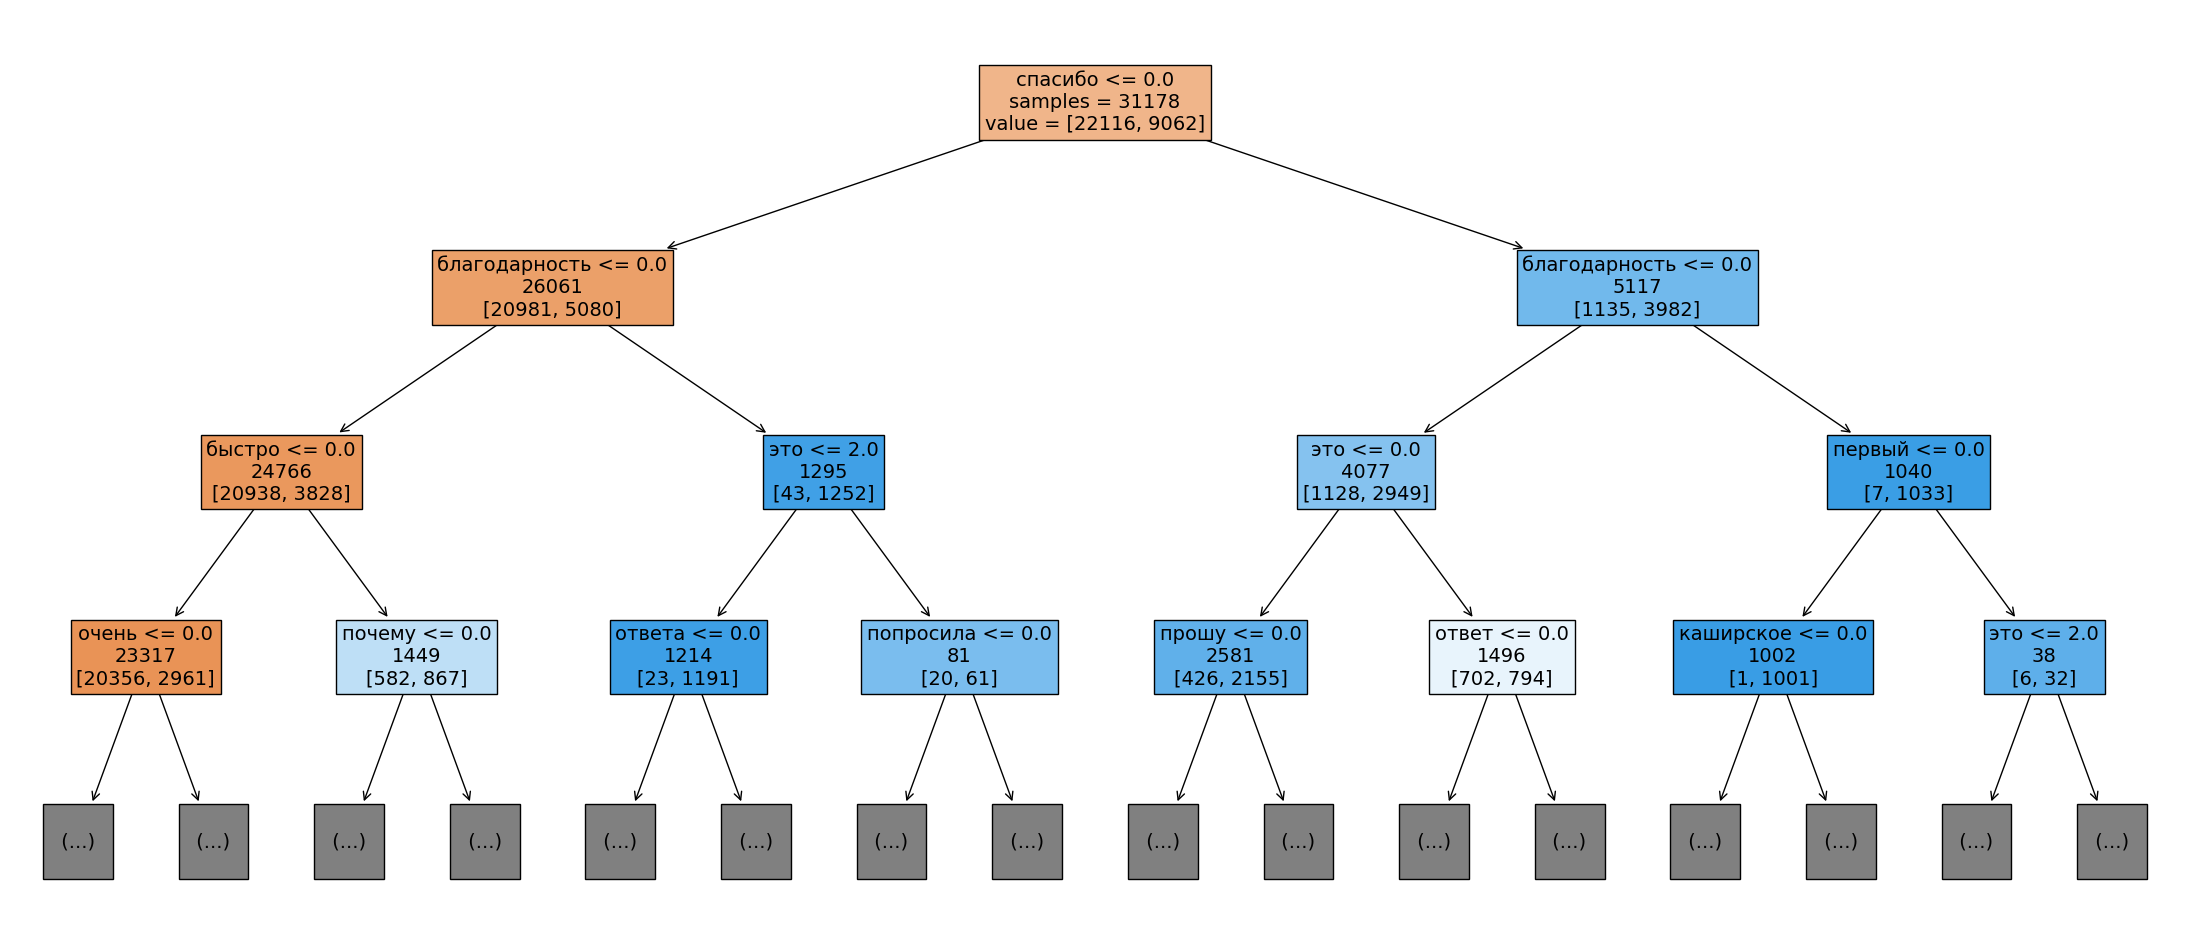

In [55]:
plt.style.use('default')
plt.figure(figsize=(28,12))
plot_tree(
    clf, max_depth=3, fontsize=14, filled=True, precision=0, label='root',
    impurity=False, feature_names=features
);

In [56]:
plt.style.use('ggplot')

## Модель на n-gram'ах символов. TfidfVectorizer

In [57]:
def preprocessor(text):
    whitespaced_text = re.sub("[^а-яё!:)(]", ' ', text.lower())
    return re.sub(' +', ' ',  whitespaced_text)

In [58]:
char_tfidf_model = Pipeline([
    (
        'vectorizer',
        TfidfVectorizer(
            lowercase=True, ngram_range=(2, 4), analyzer='char',
            preprocessor=preprocessor, min_df=5, max_df=0.8
        )
    ),
    ('clf', SGDClassifier(random_state=SEED, loss='log', class_weight='balanced'))
])

In [59]:
char_tfidf_model.fit(x_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', max_df=0.8, min_df=5,
                                 ngram_range=(2, 4),
                                 preprocessor=<function preprocessor at 0x7fe08b713760>)),
                ('clf',
                 SGDClassifier(class_weight='balanced', loss='log',
                               random_state=42))])

In [71]:
len(char_tfidf_model.steps[0][1].vocabulary_)

63817

In [72]:
weights = char_tfidf_model.steps[1][1].coef_[0]

In [74]:
feature_names = np.array(
    sorted(
        char_tfidf_model.steps[0][1].vocabulary_
    )
)

In [82]:
char_tfidf_model.steps[0][1].vocabulary_

{'оф': 40794,
 'фо': 54199,
 'рм': 44445,
 'мл': 33719,
 'ии': 25348,
 ' а': 458,
 'вт': 14067,
 'ок': 38974,
 'кр': 29692,
 'ди': 16573,
 'вя': 14476,
 'яз': 62451,
 'ус': 53041,
 'лу': 31947,
 'уг': 51992,
 'гу': 15628,
 'ощ': 41105,
 'щь': 57986,
 'га': 14862,
 'ах': 10265,
 'х ': 54498,
 'р ': 42767,
 'бе': 11199,
 'ез': 19098,
 'з ': 22390,
 'бр': 11831,
 'ря': 45748,
 'яю': 63126,
 'ют': 61551,
 'мн': 33814,
 'ну': 36560,
 'уж': 52252,
 'жн': 22201,
 'сп': 47561,
 'ьз': 60170,
 'зо': 23565,
 'ьс': 60353,
 ' е': 1373,
 'ей': 19283,
 'из': 25198,
 'уд': 52089,
 'нн': 36007,
 'ож': 38603,
 'жи': 22057,
 'ив': 24738,
 'дл': 16788,
 'ля': 32427,
 'бс': 11924,
 'тв': 49396,
 'оп': 39852,
 'пл': 41977,
 'ты': 51015,
 'ми': 33517,
 'рт': 45053,
 'ту': 50793,
 'кл': 29321,
 'лю': 32316,
 'юч': 61629,
 'ч ': 56007,
 'ая': 10638,
 'дс': 17249,
 'ви': 13299,
 'сь': 48329,
 'ои': 38800,
 'вк': 13494,
 'рг': 43537,
 'тк': 50006,
 'зы': 23854,
 'ыв': 58590,
 'аю': 10581,
 'тс': 50683,
 'рв': 43

In [76]:
order = weights.argsort()

In [77]:
feature_names[order][-20:]

array(['лаг', 'ыстр', 'быс', 'быст', ' быс', 'бла', 'пас', 'дар', 'аго',
       'благ', 'лаго', ' спа', 'сиб', 'одар', 'спа', 'агод', 'паси',
       'асиб', 'сибо', 'спас'], dtype='<U4')

In [80]:
f1_score(y_train, char_tfidf_model.predict(x_train))

0.9359480028887284

In [81]:
f1_score(y_val, char_tfidf_model.predict(x_val))

0.9265687583444592

## Подбор параметров с помощью кросс-валидации

In [85]:
parameters = {
    'vectorizer__max_df': (0.5, 0.75),
    'vectorizer__min_df': (3, 5, 7),
    'clf__alpha': (0.0001, 0.001, 0.01),
}

In [86]:
grid_search = GridSearchCV(count_model, parameters, cv=3, n_jobs=-1, scoring='f1', verbose=1)

In [87]:
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/Users/k.shematorov/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/k.shematorov/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/k.shematorov/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/k.shematorov/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which 

/Users/k.shematorov/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/k.shematorov/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/k.shematorov/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/k.shematorov/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(max_df=0.8, min_df=3,
                                                        stop_words=['и', 'в',
                                                                    'во', 'не',
                                                                    'что', 'он',
                                                                    'на', 'я',
                                                                    'с', 'со',
                                                                    'как', 'а',
                                                                    'то', 'все',
                                                                    'она',
                                                                    'так',
                                                                    'его', 'но',
                                                                    'да', 'ты',
                                                                    'к', 'у',
                                                                    'же', 'вы',
                                                                    'за', 'бы',
                                                                    'по',
                                                                    'только',
                                                                    'ее', 'мне', ...],
                                                        token_pattern='[а-яё]+')),
                                       ('clf',
                                        SGDClassifier(class_weight='balanced',
                                                      loss='log',
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.0001, 0.001, 0.01),
                         'vectorizer__max_df': (0.5, 0.75),
                         'vectorizer__min_df': (3, 5, 7)},
             scoring='f1', verbose=1)

In [88]:
best_parameters = grid_search.best_estimator_.get_params()

In [89]:
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

	clf__alpha: 0.001
	vectorizer__max_df: 0.5
	vectorizer__min_df: 3


In [99]:
mean_score

array([0.91344908, 0.91078011, 0.90854837, 0.91065365, 0.90504006,
       0.90848255, 0.92058936, 0.92026197, 0.92015274, 0.91846355,
       0.91834261, 0.91812149, 0.90869133, 0.90886056, 0.9087116 ,
       0.90854021, 0.90847071, 0.90848146])

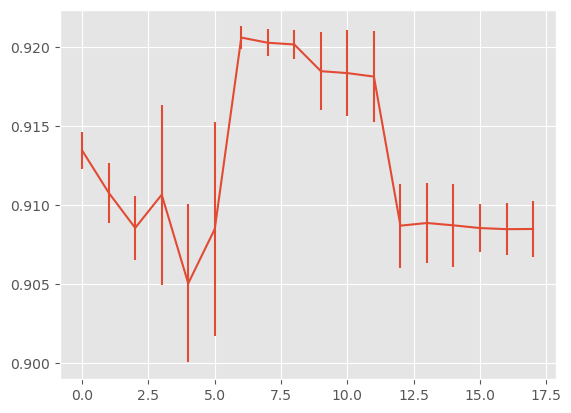

In [90]:
mean_score = grid_search.cv_results_['mean_test_score']
std_score = grid_search.cv_results_['std_test_score']
x = np.arange(0, mean_score.size)

plt.errorbar(x, mean_score, yerr=std_score);

In [100]:
grid_search.cv_results_

{'mean_fit_time': array([5.09076691, 5.25994301, 5.33125202, 5.33980807, 5.35346834,
        5.47799238, 5.47636191, 5.44406446, 5.50965158, 5.5660127 ,
        5.30216416, 5.01040125, 5.03148095, 5.050481  , 5.25047819,
        5.3038319 , 4.08413641, 3.50810107]),
 'std_fit_time': array([0.14077892, 0.02837981, 0.04553638, 0.0300196 , 0.07492798,
        0.15582825, 0.07313077, 0.04584028, 0.04962614, 0.03004478,
        0.1707781 , 0.05411894, 0.03963402, 0.04953442, 0.09442091,
        0.0252002 , 0.17126296, 0.11569829]),
 'mean_score_time': array([2.27461012, 2.31045667, 2.55747398, 2.58574828, 2.45858614,
        2.54015501, 2.54953504, 2.40693108, 2.31220015, 2.2523129 ,
        2.27892041, 2.40922109, 2.53749339, 2.46331334, 2.0276835 ,
        1.68960961, 1.1805505 , 1.10058467]),
 'std_score_time': array([0.01155742, 0.02566972, 0.05975811, 0.0607989 , 0.03630889,
        0.03857832, 0.02487363, 0.05742677, 0.01986643, 0.02229922,
        0.01345014, 0.07160675, 0.01553529, 

In [101]:
cv_tuned_pipeline = grid_search.best_estimator_

In [102]:
f1_score(
    y_train,
    cv_tuned_pipeline.predict(x_train)
)

0.9601796571178178

In [103]:
f1_score(
    y_val,
    cv_tuned_pipeline.predict(x_val)
)

0.9145466405740378

## Объединение признаков

In [95]:
pipeline = Pipeline([
    (
        'features', 
        ColumnTransformer([
            (
                'title', 
                TfidfVectorizer(
                    lowercase=True, ngram_range=(1, 2), token_pattern=TOKEN_PATTERN,
                    stop_words=stop_words, min_df=5, max_df=0.75
                ), 
                'title'
            ),
            (
                'body',
                CountVectorizer(
                    lowercase=True, ngram_range=(1, 1), token_pattern=TOKEN_PATTERN,
                    stop_words=stop_words, min_df=3, max_df=0.75
                ), 
                'body'
            )
        ])
    ),
    ('clf', SGDClassifier(random_state=SEED, alpha=0.01))
])

In [96]:
pipeline.fit(df_train, y_train)

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('title',
                                                  TfidfVectorizer(max_df=0.75,
                                                                  min_df=5,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words=['и',
                                                                              'в',
                                                                              'во',
                                                                              'не',
                                                                              'что',
                                                                              'он',
                                                                              'на',
                                                                              'я',
                                                                              'с',
                                                                              'со',
                                                                              'как',
                                                                              'а',
                                                                              'то',
                                                                              'все',
                                                                              'она',
                                                                              'так',
                                                                              'его',
                                                                              'но',
                                                                              'да',
                                                                              'ты',
                                                                              'к',
                                                                              'у',
                                                                              'же',
                                                                              'вы',
                                                                              'за',
                                                                              'бы',
                                                                              'по',
                                                                              'только',
                                                                              'ее',
                                                                              'мне', ...],
                                                                  token_pattern='[а-яё]+'),
                                                  'title'),
                                                 ('body',
                                                  CountVectorizer(max_df=0.75,
                                                                  min_df=3,
                                                                  stop_words=['и',
                                                                              'в',
                                                                              'во',
                                                                              'не',
                                                                              'что',
                                                                              'он',
                                                                              'на',
                                                                              'я',
                           

In [97]:
f1_score(
    y_train,
    pipeline.predict(df_train)
)

0.9442055163713515

In [98]:
f1_score(
    y_val,
    pipeline.predict(df_val)
)

0.9216272121351414

получите признаки из векторизатора. посмотрите на добавленные биграммы

In [104]:
vectorizer = pipeline["features"].named_transformers_["title"]

In [110]:
sorted(vectorizer.vocabulary_)

['аа',
 'ааа',
 'аб',
 'абакан',
 'абакана',
 'абзац',
 'абк',
 'абон',
 'абонемент',
 'абонемента',
 'абонент',
 'абонента',
 'абонентов',
 'абонентом',
 'абонентская',
 'абонентский',
 'абонентского',
 'абонентское',
 'абонентской',
 'абонентскую',
 'абоненту',
 'абонплату',
 'абонплаты',
 'абрамова',
 'абс',
 'абсолют',
 'абсолюта',
 'абсолютбанк',
 'абсолюте',
 'абсолютная',
 'абсолютно',
 'абсолютного',
 'абсолютное',
 'абсолютной',
 'абсолютную',
 'абсолютный',
 'абсолютным',
 'абстрактно',
 'абсурд',
 'абсурда',
 'абсурдная',
 'абсурдно',
 'абсурдное',
 'абсурдной',
 'абсурдности',
 'абсурдность',
 'абсурдную',
 'абсурдны',
 'абсурдные',
 'абсурдный',
 'абсурдным',
 'абсурдом',
 'абы',
 'авангард',
 'авангарда',
 'авангарде',
 'аванс',
 'аванса',
 'авансовой',
 'авансовому',
 'авансовый',
 'авансом',
 'авансы',
 'авантюру',
 'аварии',
 'аварию',
 'авг',
 'август',
 'августа',
 'августе',
 'августовский',
 'августу',
 'авиа',
 'авиабилет',
 'авиабилета',
 'авиабилетам',
 'авиабил

## Визуализация отзывов

Мы обучали модель классификации с помощью бинарной кросс-энтропии (log_loss):
$$
L = - y \log\left(\hat{y}\right) - (1 - y) \log\left(1 - \hat{y}\right)
$$

первое слагаемое в функции потерь отвечает за ложно-положительные срабатывания, второе — за ложно-отрицательные

посмотрим, на каких примерах полученная модель сильнее всего ошибается в одну и другую сторону

In [107]:
y_val_proba = count_model.predict_proba(x_val)[:, 1]

y_val_rating = df_val.reset_index().rating.values

In [108]:
def false_positive(y, y_proba, eps=1e-15):
    if y:
        return (-y) * np.log(y_proba + eps)
    else:
        return 0.0

def false_negative(y, y_proba, eps=1e-15):
    if y:
        return 0.0
    else:
        return (y - 1) * np.log(1 - y_proba + eps)


review_count = 5


positive_error = np.array([false_positive(y, y_proba) for (y, y_proba) in zip(y_val, y_val_proba)])

negative_error = np.array([false_negative(y, y_proba) for (y, y_proba) in zip(y_val, y_val_proba)])

max_loss_ids = np.concatenate((
    positive_error.argsort()[::-1][:review_count],
    negative_error.argsort()[::-1][:review_count]
))

In [111]:
vectorizer = count_model.steps[0][1]

token2id = {token: i for i, token in enumerate(sorted(vectorizer.vocabulary_))}

importance = count_model.steps[1][1].coef_[0]

min_importance = importance.min()
max_importance = importance.max()

In [119]:
token2id['моментально']

15331

In [120]:
weight = importance[token2id['моментально']]

In [121]:
weight

0.6449063469936269

In [112]:
for i in max_loss_ids:
    review_body = x_val[i]
    
    print(f'rating: {y_val_rating[i]}')
    print(f'predicted proba: {y_val_proba[i]}')
    
    review_tokens = re.findall(TOKEN_PATTERN, review_body.lower())
    
    html_string = '''
    <p style="font-size:16px; color:#000000; border: 2px solid #000; text-align: justify; background-color:#ffffff; border-radius: 25px; padding: 20px;">
    '''

    for token in review_tokens:
        if token in token2id:
            weight = importance[token2id[token]]
            if weight < 0:
                component = hex(int(255 - 255 * weight / min_importance))[2:]
                color = f'{component}{component}ff'
            else:
                component = hex(int(255 - 255 * weight / max_importance))[2:]
                color = f'ff{component}{component}'
        else:
            weight = 0.0
            color = 'ffffff'
        html_string += f'<span style="background-color: #{color}"; title="{weight:.2f}">{token}</span> '

    html_string += '</p>'

    display(HTML(html_string))

rating: 5
predicted proba: 2.730241377105066e-10


rating: 4
predicted proba: 1.7047224163873442e-08


rating: 5
predicted proba: 6.097717358665765e-08


rating: 4
predicted proba: 1.0147657854859243e-06


rating: 4
predicted proba: 1.2162001458849035e-06


rating: 1
predicted proba: 0.9996527536516763


rating: 1
predicted proba: 0.9988035246131061


rating: 1
predicted proba: 0.998653195578374


rating: 1
predicted proba: 0.9986151120201464


rating: 2
predicted proba: 0.9978225222466653


если присмотреться, то ошибки модели связаны с ошибками в разметке

# Проблемы анализа тональности

это двойные отрицания и сарказм

In [122]:
sentences = [
    'ну да, блин, отношение к клиентам супер, спасибо вам...',
    'такой клиентоориентированности я еще не видел, сказочные ...',
    'выражаю огромную благодарность банку, третий раз пытаюсь оформить доставку карты, но воз и ныне там',
    'я думал, что банк окажется хуже некуда, но обошлось',
    'раньше ненавидел сбербанк, а теперь всем советую'
]

labels = [0, 0, 0, 1, 1]

predictions = count_model.predict_proba(sentences)[:, 1]


for sentence, label, prediction in zip(sentences, labels, predictions):
    print(sentence)
    print(f"TRUE: {label} PREDICTED: {prediction:.2f}\n")
    print("#" * 100, end='\n\n')

ну да, блин, отношение к клиентам супер, спасибо вам...
TRUE: 0 PREDICTED: 0.89

####################################################################################################

такой клиентоориентированности я еще не видел, сказочные ...
TRUE: 0 PREDICTED: 0.61

####################################################################################################

выражаю огромную благодарность банку, третий раз пытаюсь оформить доставку карты, но воз и ныне там
TRUE: 0 PREDICTED: 0.95

####################################################################################################

я думал, что банк окажется хуже некуда, но обошлось
TRUE: 1 PREDICTED: 0.51

####################################################################################################

раньше ненавидел сбербанк, а теперь всем советую
TRUE: 1 PREDICTED: 0.39

####################################################################################################

